| Action | Time | Notes|
|  ----  |  --- |  --- |
| Open Remote Dataset (fsspec + xarray) | 35 s | Use `simple_templates=True` |
| Plotting + animation | 5 min 30 s | |

***

## Important Requirements

* adlfs >= 0.7.7
* fsspec >= 2021.06.1


In [1]:
from IPython.display import HTML

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import datetime as dt
import zipfile
import logging
import fsspec
import ujson
from tqdm import tqdm
from glob import glob
import os

from azure.storage.blob import ContainerClient
import tempfile
from metpy import xarray

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd

In [3]:
from dask.distributed import Client
client = Client()
client

/srv/conda/envs/notebook/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43623 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:34735 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 32.00 GiB


In [4]:
connection_string = os.getenv('azure_connection_string')

In [5]:
%%time
fs = fsspec.filesystem('reference', 
                       fo='zip://combined.json::combined.zip', 
                       remote_protocol='az', 
                       remote_options={'account_name':'goeseuwest'}, 
                       simple_templates=True)

m = fs.get_mapper("")

ds = xr.open_dataset(m, engine='zarr', chunks='auto')

CPU times: user 36.6 s, sys: 2.12 s, total: 38.7 s
Wall time: 37.9 s


In [6]:
ds

<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, t: 144, x: 5424, y: 5424)
Coordinates: (12/37)
    band_id_C01                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C02                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C03                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C04                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C05                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C06                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                      ...
    band_wavelength_C16                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
  * t                                       (t) datetime64[ns] 2020-01-02T00:...
  * x                                       (x) float32 -0.1518 ... 0.1518
    x_image                                 float32 ...
  * y                                       (y) float32 0.1518 ... -0.1518
    y_image                                 float32 ...
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables: (12/124)
    CMI_C01                                 (t, y, x) float32 dask.array<chunksize=(8, 1808, 1808), meta=np.ndarray>
    CMI_C02                                 (t, y, x) float32 dask.array<chunksize=(8, 1808, 1808), meta=np.ndarray>
    CMI_C03                                 (t, y, x) float32 dask.array<chunksize=(8, 1808, 1808), meta=np.ndarray>
    CMI_C04                                 (t, y, x) float32 dask.array<chunksize=(8, 1808, 1808), meta=np.ndarray>
    CMI_C05                                 (t, y, x) float32 dask.array<chunksize=(8, 1808, 1808), meta=np.ndarray>
    CMI_C06                                 (t, y, x) float32 dask.array<chunksize=(8, 1808, 1808), meta=np.ndarray>
    ...                                      ...
    std_dev_reflectance_factor_C04          (t) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    std_dev_reflectance_factor_C05          (t) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    std_dev_reflectance_factor_C06          (t) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    time_bounds                             (t, number_of_time_bounds) datetime64[ns] dask.array<chunksize=(144, 2), meta=np.ndarray>
    x_image_bounds                          (number_of_image_bounds) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    y_image_bounds                          (number_of_image_bounds) float32 dask.array<chunksize=(2,), meta=np.ndarray>
Attributes: (12/29)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    cdm_data_type:             Image
    dataset_name:              OR_ABI-L2-MCMIPF-M6_G16_s20200020000216_e20200...
    date_created:              2020-01-02T00:10:03.1Z
    id:                        087244ef-58ee-4c60-a351-2d8b63086250
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   Multiple reflectance and emissive channel Clou...
    time_coverage_end:         2020-01-02T00:09:52.4Z
    time_coverage_start:       2020-01-02T00:00:21.6Z
    timeline_id:               ABI Mode 6
    title:                     ABI L2 Cloud and Moisture Imagery

## Lat/lon

In [7]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm 

    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"

    return ds

In [8]:
def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))


In [9]:
ds = calc_latlon(ds)

/tmp/ipykernel_3283/2211100413.py:21: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


In [10]:
top = 49.3457868 # north lat
left = -124.7844079 # west long
right = -66.9513812 # east long
bottom =  24.7433195 # south lat

lats = (bottom, top)
lons = (left, right)

((x1, x2), (y1,y2)) = get_xy_from_latlon(ds, lats, lons)

In [11]:
%%time
subset = ds.sel(x=slice(x1, x2), y=slice(y2,y1))
subset

CPU times: user 18.4 ms, sys: 7.95 ms, total: 26.3 ms
Wall time: 23 ms


<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, t: 144, x: 2440, y: 1020)
Coordinates: (12/39)
    band_id_C01                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C02                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C03                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C04                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C05                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C06                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                      ...
  * x                                       (x) float32 -0.1144 ... 0.0222
    x_image                                 float32 ...
  * y                                       (y) float32 0.126 0.126 ... 0.06896
    y_image                                 float32 ...
    lat                                     (y, x) float32 nan nan ... 23.34
    lon                                     (y, x) float32 nan nan ... -67.06
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables: (12/124)
    CMI_C01                                 (t, y, x) float32 dask.array<chunksize=(8, 1020, 1139), meta=np.ndarray>
    CMI_C02                                 (t, y, x) float32 dask.array<chunksize=(8, 1020, 1139), meta=np.ndarray>
    CMI_C03                                 (t, y, x) float32 dask.array<chunksize=(8, 1020, 1139), meta=np.ndarray>
    CMI_C04                                 (t, y, x) float32 dask.array<chunksize=(8, 1020, 1139), meta=np.ndarray>
    CMI_C05                                 (t, y, x) float32 dask.array<chunksize=(8, 1020, 1139), meta=np.ndarray>
    CMI_C06                                 (t, y, x) float32 dask.array<chunksize=(8, 1020, 1139), meta=np.ndarray>
    ...                                      ...
    std_dev_reflectance_factor_C04          (t) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    std_dev_reflectance_factor_C05          (t) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    std_dev_reflectance_factor_C06          (t) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    time_bounds                             (t, number_of_time_bounds) datetime64[ns] dask.array<chunksize=(144, 2), meta=np.ndarray>
    x_image_bounds                          (number_of_image_bounds) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    y_image_bounds                          (number_of_image_bounds) float32 dask.array<chunksize=(2,), meta=np.ndarray>
Attributes: (12/29)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    cdm_data_type:             Image
    dataset_name:              OR_ABI-L2-MCMIPF-M6_G16_s20200020000216_e20200...
    date_created:              2020-01-02T00:10:03.1Z
    id:                        087244ef-58ee-4c60-a351-2d8b63086250
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   Multiple reflectance and emissive channel Clou...
    time_coverage_end:         2020-01-02T00:09:52.4Z
    time_coverage_start:       2020-01-02T00:00:21.6Z
    timeline_id:               ABI Mode 6
    title:                     ABI L2 Cloud and Moisture Imagery

### Calculate true color
https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html

CPU times: user 2.21 s, sys: 322 ms, total: 2.54 s
Wall time: 43 s


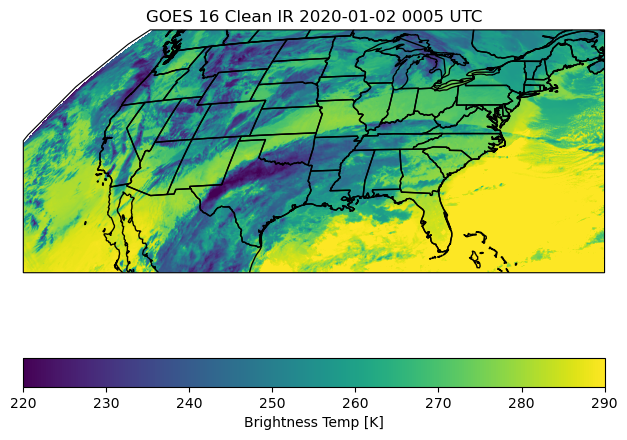

In [12]:
%%time
nt = len(subset.t)

from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(7.5,7.5), dpi=100)

dummy_channel = subset.metpy.parse_cf('CMI_C01')
x = dummy_channel.x; y = dummy_channel.y
ax = fig.add_subplot(111, projection = dummy_channel.metpy.cartopy_crs)

p = ax.imshow(subset.CMI_C13.isel(t=0), origin='upper', extent=(x.min(), x.max(), y.min(), y.max()),
         vmin=220, vmax=290)
ax.coastlines()
ax.add_feature(ccrs.cartopy.feature.BORDERS)
ax.add_feature(ccrs.cartopy.feature.STATES)

ts = pd.to_datetime(str(subset.t[0].values)).strftime("%Y-%m-%d %H%M UTC")
ax.set_title(f"GOES 16 Clean IR {ts}")
plt.colorbar(p, orientation='horizontal', label='Brightness Temp [K]', ax=ax)


def update_anim(i):
    ts = pd.to_datetime(str(subset.t[i].values)).strftime("%Y-%m-%d %H%M UTC")
    
    ax.clear()
    
    p = ax.imshow(subset.CMI_C13.isel(t=i), origin='upper', extent=(x.min(), x.max(), y.min(), y.max()),
                 vmin=220, vmax=290)
    ax.set_title(f"GOES 16 Clean IR {ts}")
    ax.coastlines()
    ax.add_feature(ccrs.cartopy.feature.BORDERS)
    ax.add_feature(ccrs.cartopy.feature.STATES)
#     plt.colorbar(p, orientation='horizontal', label='Brightness Temperature [K]', ax=ax)
    

    return p
  
# update_anim(1)
animator = FuncAnimation(fig, update_anim, frames=nt, interval=50)
# plt.show()

In [13]:
%time HTML(animator.to_html5_video())

CPU times: user 1min 13s, sys: 4.32 s, total: 1min 18s
Wall time: 2min 44s


# Make a veggie-color image of the East Coast using GOES-17 (east) data

CPU times: user 12.4 s, sys: 5.17 s, total: 17.5 s
Wall time: 37.3 s


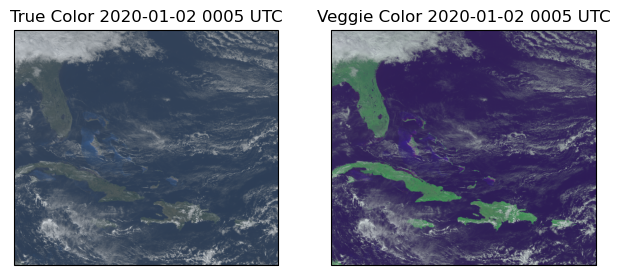

In [14]:
%%time
top = 35 # north lat
left = -84 # west long
right = -64 # east long
bottom =  15 # south lat

lats = (bottom, top)
lons = (left, right)

((x1, x2), (y1,y2)) = get_xy_from_latlon(ds, lats, lons)

subset = ds.sel(x=slice(x1, x2), y=slice(y2,y1))
subset

nt = len(subset.t)

#from matplotlib.animation import FuncAnimation


dummy_channel = subset.metpy.parse_cf('CMI_C01')
x = dummy_channel.x; y = dummy_channel.y

# https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html
# Load the three channels into appropriate R, G, and B variables
#removed .data here, not necessary & actually a little nicer to keep metadata attached
R = subset['CMI_C02']#.data  
G = subset['CMI_C03']#.data
B = subset['CMI_C01']#.data
# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)
# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)
# Calculate the "True" Green
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.clip(G_true, 0, 1)  # apply limits again, just in case.

Rr,Gr,G_truer,Br=R.isel(t=110),G.isel(t=110),G_true.isel(t=110),B.isel(t=110)

# The RGB array with the raw veggie band
RGB_veggie = np.dstack([Rr, Gr, Br])
# The RGB array for the true color image
RGB = np.dstack([Rr, G_truer, Br])

#p = ax.imshow(RGB_veggie, origin='upper', extent=(x.min(), x.max(), y.min(), y.max())) #,vmin=220, vmax=290)
fig = plt.figure(figsize=(7.5,7.5), dpi=100)
for ifig in range(121,123):
    ax = fig.add_subplot(ifig, projection = dummy_channel.metpy.cartopy_crs)
    if ifig==121:
        p = ax.imshow(RGB, origin='upper', vmin=0, vmax=1)
        ax.set_title(f"True Color {ts}")
    if ifig==122:
        p = ax.imshow(RGB_veggie, origin='upper', vmin=0, vmax=1)
        ax.set_title(f"Veggie Color {ts}")
    ax.coastlines()
    ax.add_feature(ccrs.cartopy.feature.BORDERS)
    ax.add_feature(ccrs.cartopy.feature.STATES)
    ts = pd.to_datetime(str(subset.t[0].values)).strftime("%Y-%m-%d %H%M UTC")

#plt.colorbar(p, orientation='horizontal', label='Brightness Temp [K]', ax=ax)


CPU times: user 258 ms, sys: 13.4 ms, total: 271 ms
Wall time: 1.24 s


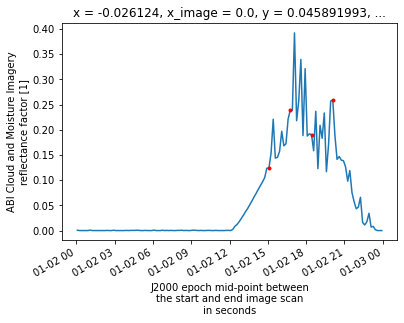

In [15]:
%%time
#plot time series and value of a few points
iy,ix=-10,10
subset.CMI_C05[:,iy,ix].plot()
for it in [90,100,110,120]:
    plt.plot(subset.t[it],subset.CMI_C05[it,iy,ix],'r.')

CPU times: user 200 ms, sys: 24.6 ms, total: 225 ms
Wall time: 208 ms


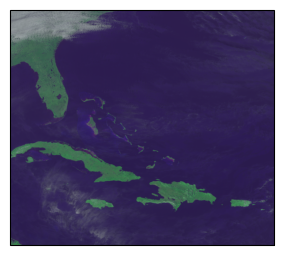

In [16]:
%%time
#try to remove most clouds by looking at daytime min
Rsubset = R.isel(t=slice(90,120))
imax = Rsubset.argmin(dim='t')+90
Rr,Gr,G_truer,Br=R.isel(t=imax),G.isel(t=imax),G_true.isel(t=imax),B.isel(t=imax)
# The RGB array with the raw veggie band
RGB_veggie = np.dstack([Rr, Gr, Br])
fig = plt.figure(figsize=(7.5,7.5), dpi=100)
ax = fig.add_subplot(ifig, projection = dummy_channel.metpy.cartopy_crs)
p = ax.imshow(RGB_veggie, origin='upper')

CPU times: user 102 ms, sys: 12.2 ms, total: 114 ms
Wall time: 101 ms


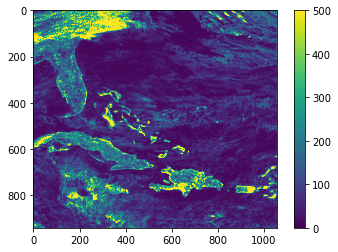

In [17]:
%%time
#calculate gradients, could use for additional cloud filtering 
rsum = R.isel(t=imax)
grad_x = rsum.differentiate("x")
grad_y = rsum.differentiate("y")
plt.imshow(np.sqrt(grad_x**2+grad_y**2),vmin=0,vmax=500)
plt.colorbar()

CPU times: user 18.2 s, sys: 965 ms, total: 19.2 s
Wall time: 18.3 s


(array([1.09293742e+01, 2.68816418e-01, 3.28429998e-01, 4.28227075e-01,
        7.10097624e-01, 1.29103198e+00, 2.57169505e+00, 2.05107422e+00,
        5.73292847e-01, 2.91155432e-01, 1.82955924e-01, 1.31191695e-01,
        1.04978052e-01, 8.26794087e-02, 4.24169802e-02, 9.80204797e-03,
        2.32229967e-03, 4.34474120e-04, 2.42225238e-05]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <BarContainer object of 19 artists>)

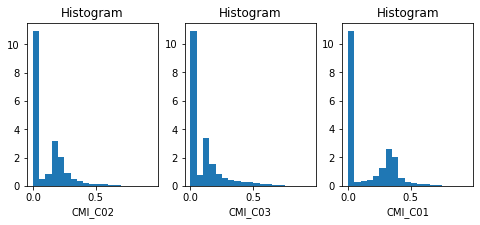

In [18]:
%%time
f, ax = plt.subplots(1, 3, figsize=(8, 3))
bins = np.arange(0,1,.05)
xr.plot.hist(R,ax=ax[0],bins=bins,density=True)
xr.plot.hist(G,ax=ax[1],bins=bins,density=True)
xr.plot.hist(B,ax=ax[2],bins=bins,density=True)